In [1]:
from src.utils import load_data
from src.model2 import Model2

%load_ext autoreload
%autoreload 2


In [2]:
vitals_path='data/vitals_ts_small.csv'
cohort_path='data/icu_cohort_small.csv'
freq='6H'
test_size=0.2
random_state=42
n_stay_ids=10000
verbose=True


In [3]:
if verbose:
    print("=" * 60)
    print("MODEL 3: Irregular-Explainable with Missingness Modeling")
    print("=" * 60)
    print(f"\nModel Type: XGBoost + SHAP")
    print(f"Resampling Frequency: {freq}")
    print(f"Test Size: {test_size}")

if verbose:
    print("\n[1/5] Loading data...")
df_vitals, df_patients = load_data(vitals_path, cohort_path)
if verbose:
    print(f"  - Loaded {len(df_patients)} patients")
    print(f"  - Loaded {len(df_vitals)} vital sign measurements")


MODEL 3: Irregular-Explainable with Missingness Modeling

Model Type: XGBoost + SHAP
Resampling Frequency: 6H
Test Size: 0.2

[1/5] Loading data...
  - Loaded 94444 patients
  - Loaded 11572805 vital sign measurements


In [ ]:
if verbose:
    print("\n[2/5] Regularizing time series with missingness features...")
model = Model2(freq=freq, random_state=random_state, n_stay_ids=n_stay_ids)

df_features = model.regularize_time_series(df_vitals, df_patients)
if verbose:
    print(f"  - Created {len(df_features.columns) - 2} features")
    print(f"  - Mortality rate: {df_features['died_in_hosp'].mean():.2%}")



[2/5] Regularizing time series with missingness features...
  - Created 240 features
  - Mortality rate: 11.88%


In [5]:
if verbose:
    print("\n[3/5] Preparing data for training...")
X_train, X_test, y_train, y_test = model.prepare_data(df_features, test_size=test_size)
if verbose:
    print(f"  - Training set: {len(X_train)} samples")
    print(f"  - Test set: {len(X_test)} samples")



[3/5] Preparing data for training...
  - Training set: 8000 samples
  - Test set: 2000 samples


In [6]:
if verbose:
    print(f"\n[4/5] Training XGBoost with SHAP explainer...")
model.fit(X_train, y_train)
if verbose:
    print("  - Training complete!")



[4/5] Training XGBoost with SHAP explainer...
  - Training complete!


In [7]:
if verbose:
    print("\n[5/5] Evaluating model...")
results = model.evaluate(X_train, X_test, y_train, y_test, verbose=verbose)



[5/5] Evaluating model...

=== Model3 XGBoost Results ===
Train Accuracy: 0.9547
Test Accuracy: 0.8895
Train AUC-ROC: 0.9844
Test AUC-ROC: 0.7821

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      1762
           1       0.67      0.14      0.23       238

    accuracy                           0.89      2000
   macro avg       0.78      0.56      0.59      2000
weighted avg       0.87      0.89      0.86      2000



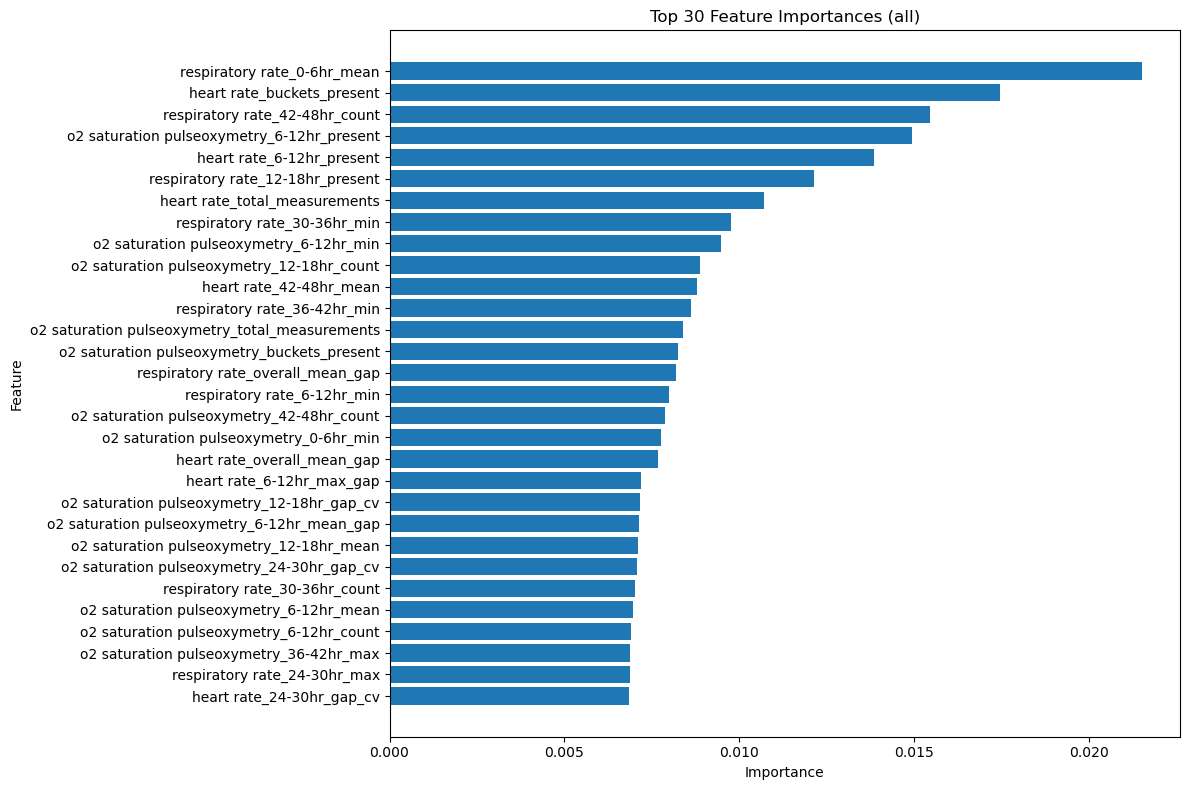

,feature,importance
0,respiratory rate_0-6hr_mean,0.021515
237,heart rate_buckets_present,0.017453
193,respiratory rate_42-48hr_count,0.015432
39,o2 saturation pulseoxymetry_6-12hr_present,0.014940
48,heart rate_6-12hr_present,0.013857
57,respiratory rate_12-18hr_present,0.012140
235,heart rate_total_measurements,0.010712
137,respiratory rate_30-36hr_min,0.009762
38,o2 saturation pulseoxymetry_6-12hr_min,0.009486
67,o2 saturation pulseoxymetry_12-18hr_count,0.008875


In [8]:
model.plot_feature_importance(top_n=30)


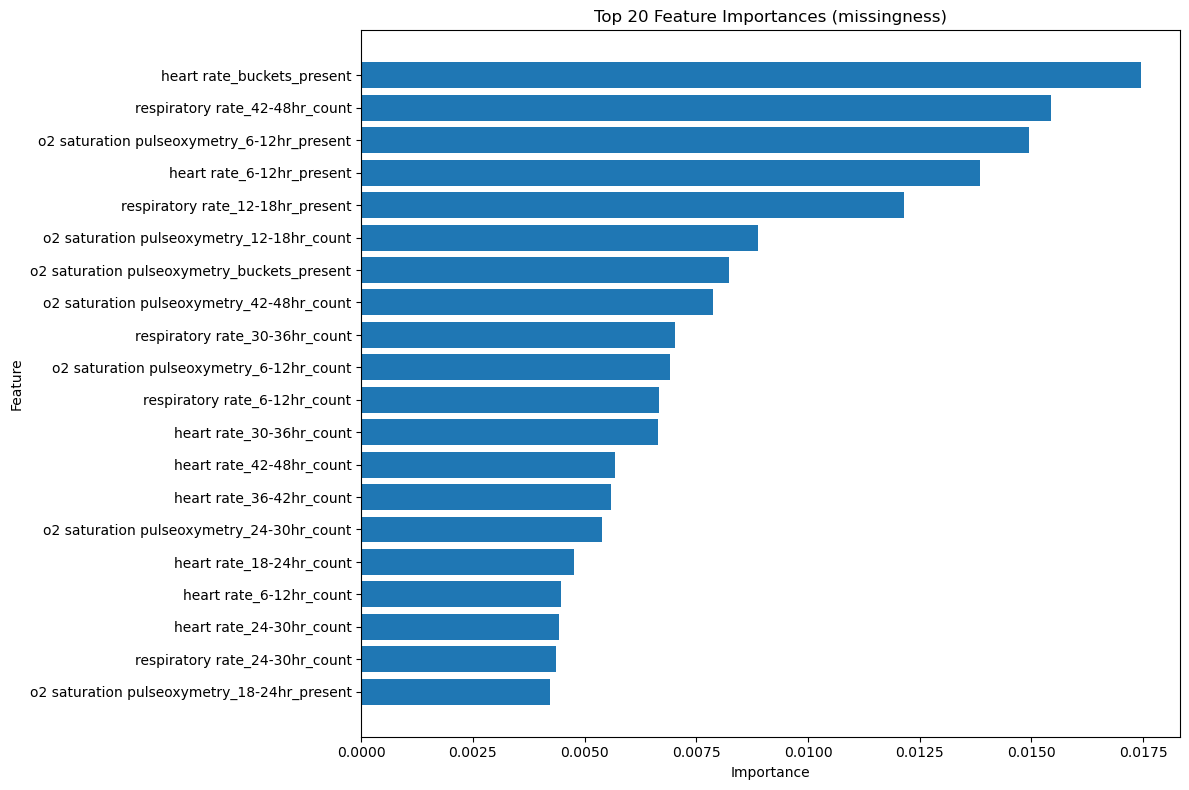

,feature,importance
237,heart rate_buckets_present,0.017453
193,respiratory rate_42-48hr_count,0.015432
39,o2 saturation pulseoxymetry_6-12hr_present,0.014940
48,heart rate_6-12hr_present,0.013857
57,respiratory rate_12-18hr_present,0.012140
67,o2 saturation pulseoxymetry_12-18hr_count,0.008875
229,o2 saturation pulseoxymetry_buckets_present,0.008237
202,o2 saturation pulseoxymetry_42-48hr_count,0.007879
139,respiratory rate_30-36hr_count,0.007022
40,o2 saturation pulseoxymetry_6-12hr_count,0.006915


In [9]:
model.plot_feature_importance(top_n=20, feature_type='missingness')


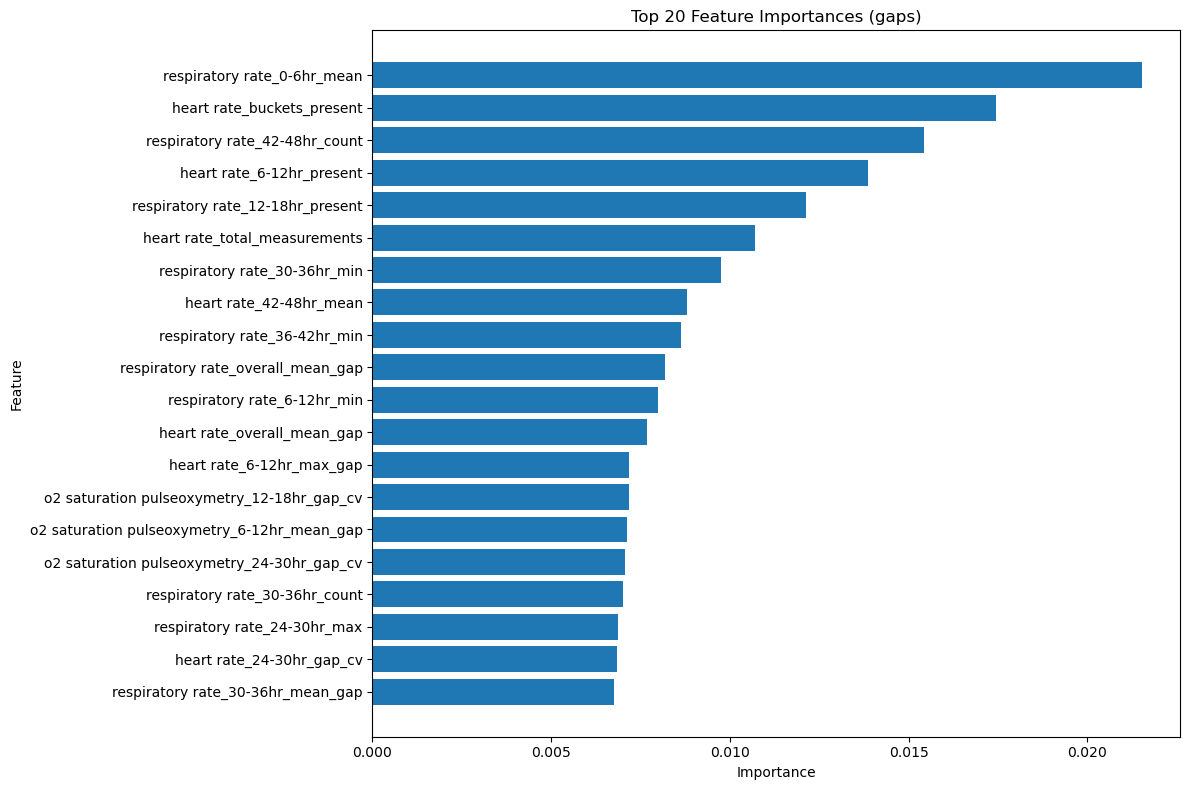

,feature,importance
0,respiratory rate_0-6hr_mean,0.021515
237,heart rate_buckets_present,0.017453
193,respiratory rate_42-48hr_count,0.015432
48,heart rate_6-12hr_present,0.013857
57,respiratory rate_12-18hr_present,0.012140
235,heart rate_total_measurements,0.010712
137,respiratory rate_30-36hr_min,0.009762
207,heart rate_42-48hr_mean,0.008801
164,respiratory rate_36-42hr_min,0.008629
216,respiratory rate_overall_mean_gap,0.008181


In [10]:
model.plot_feature_importance(top_n=20, feature_type='gaps')


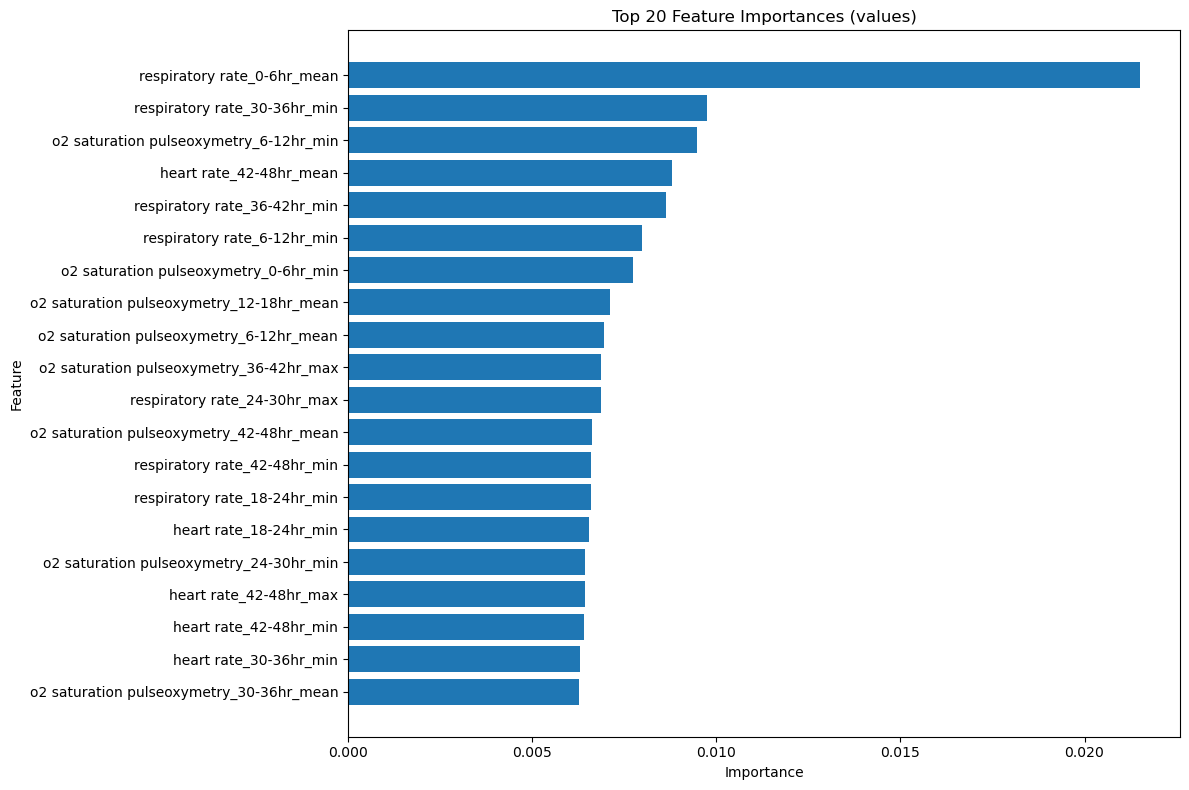

,feature,importance
0,respiratory rate_0-6hr_mean,0.021515
137,respiratory rate_30-36hr_min,0.009762
38,o2 saturation pulseoxymetry_6-12hr_min,0.009486
207,heart rate_42-48hr_mean,0.008801
164,respiratory rate_36-42hr_min,0.008629
29,respiratory rate_6-12hr_min,0.007984
11,o2 saturation pulseoxymetry_0-6hr_min,0.007751
63,o2 saturation pulseoxymetry_12-18hr_mean,0.007107
36,o2 saturation pulseoxymetry_6-12hr_mean,0.006952
172,o2 saturation pulseoxymetry_36-42hr_max,0.006864


In [11]:
model.plot_feature_importance(top_n=20, feature_type='values')


Available variables for stay_id 30000153: ['respiratory rate' 'o2 saturation pulseoxymetry' 'heart rate']


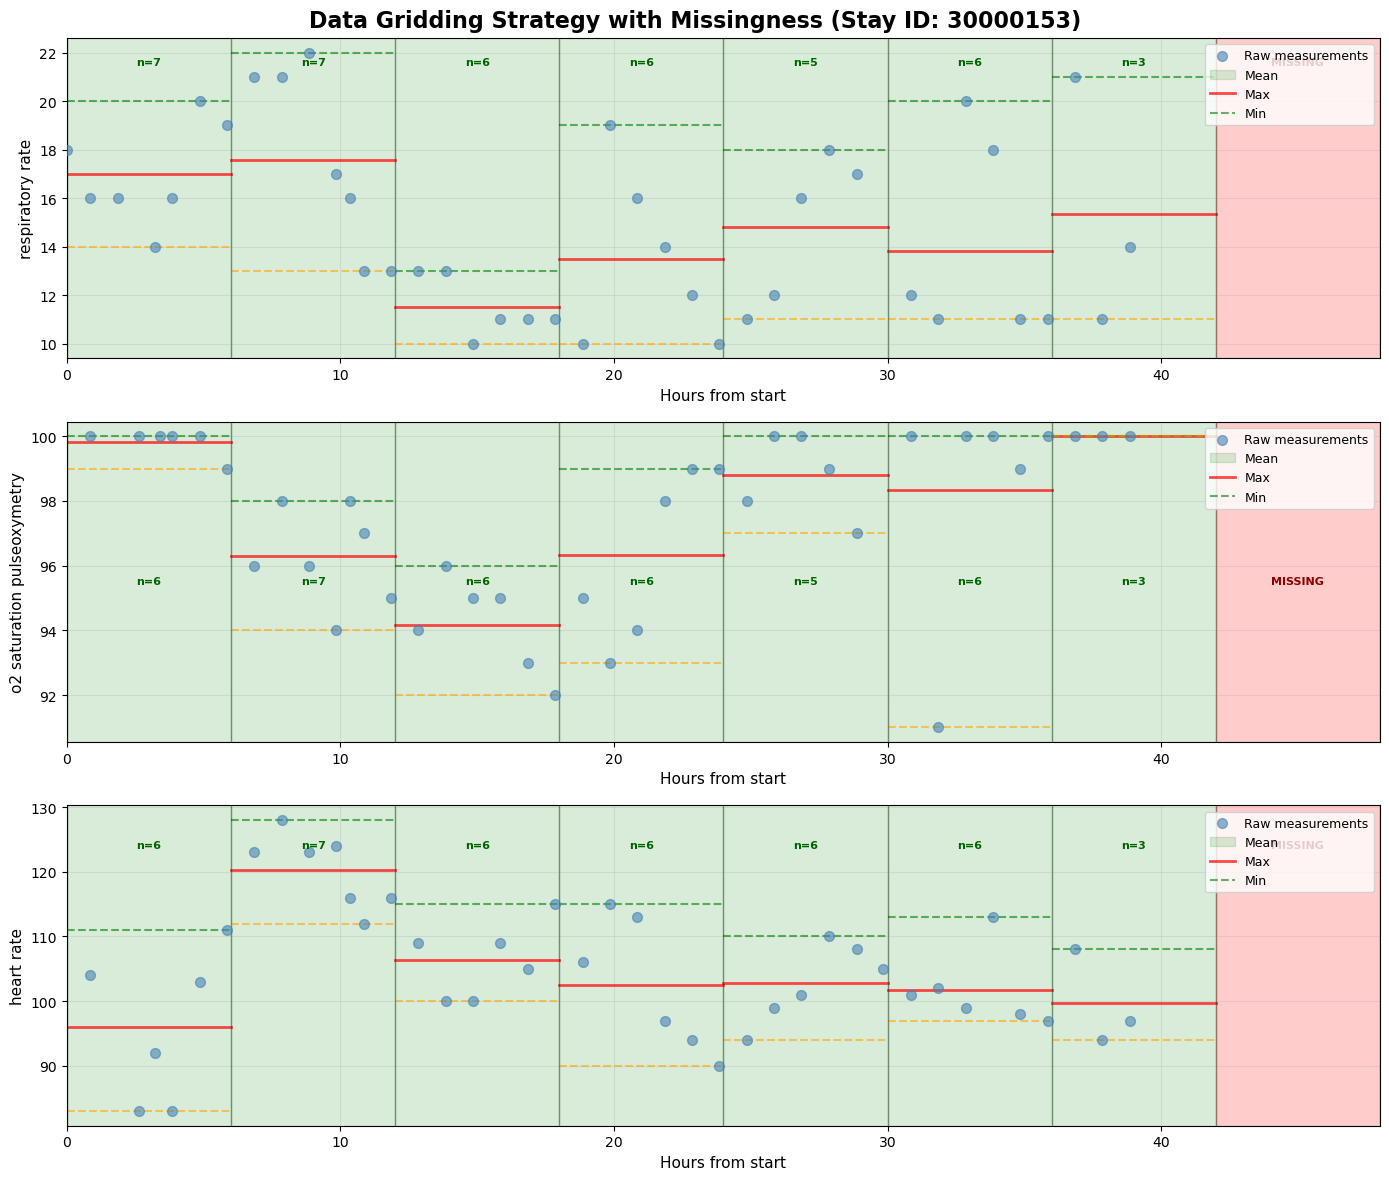

In [12]:
model.visualize(model.stay_ids[0], df_vitals)


PermutationExplainer explainer: 2001it [01:49, 16.98it/s]                          


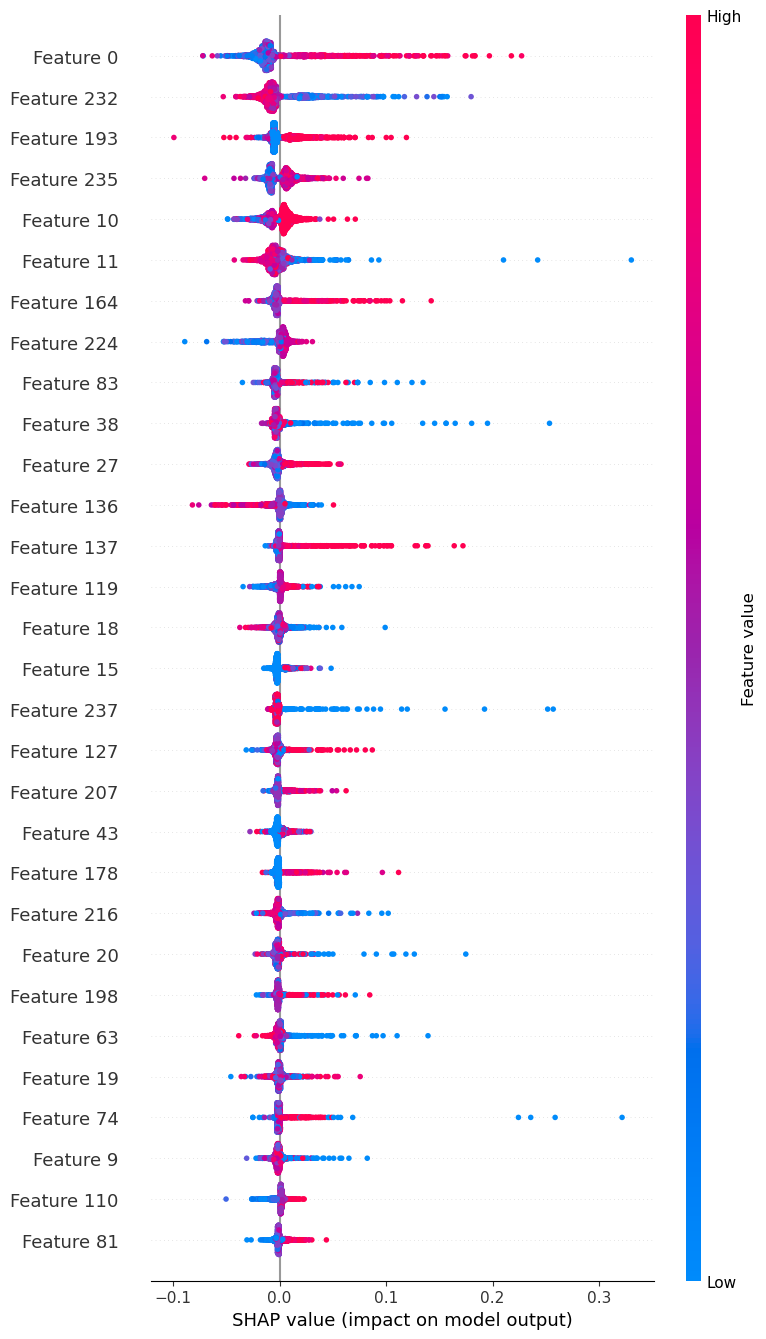

In [13]:
model.plot_shap_summary(X_test, max_display=30)


PermutationExplainer explainer: 2001it [01:49, 16.54it/s]                          


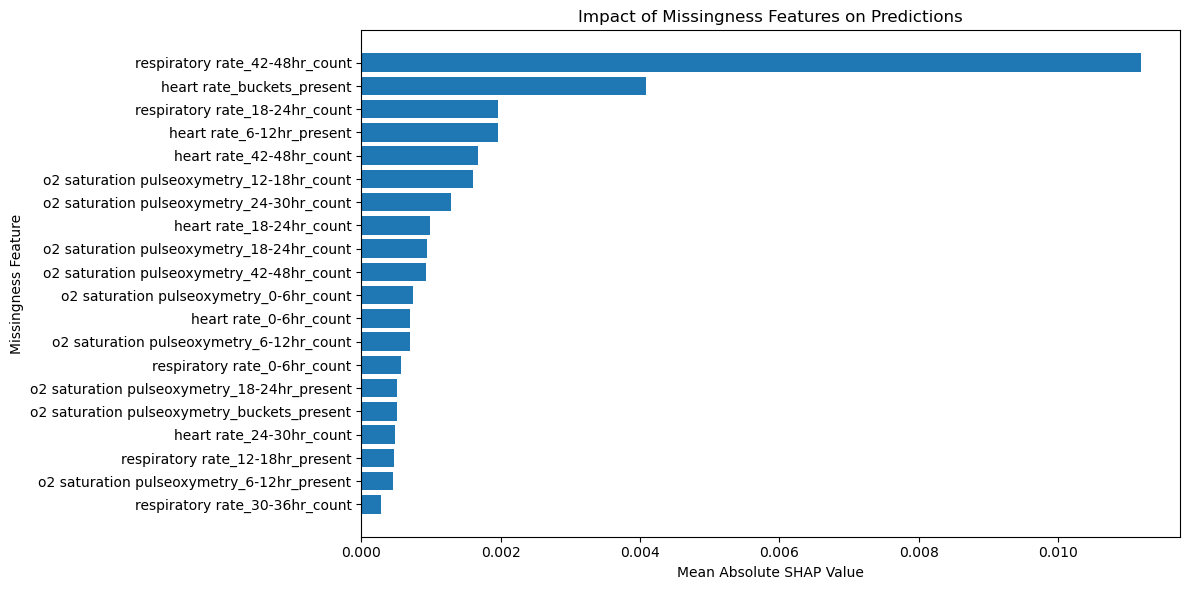

,feature,mean_abs_shap
64,respiratory rate_42-48hr_count,0.011191
78,heart rate_buckets_present,0.004081
28,respiratory rate_18-24hr_count,0.001964
15,heart rate_6-12hr_present,0.001955
70,heart rate_42-48hr_count,0.001674
...,...,...
23,o2 saturation pulseoxymetry_12-18hr_density,0.000000
53,heart rate_30-36hr_density,0.000000
54,respiratory rate_36-42hr_present,0.000000
55,respiratory rate_36-42hr_count,0.000000


In [14]:
model.analyze_missingness_impact(X_test)


PermutationExplainer explainer: 2001it [01:46, 16.93it/s]                          


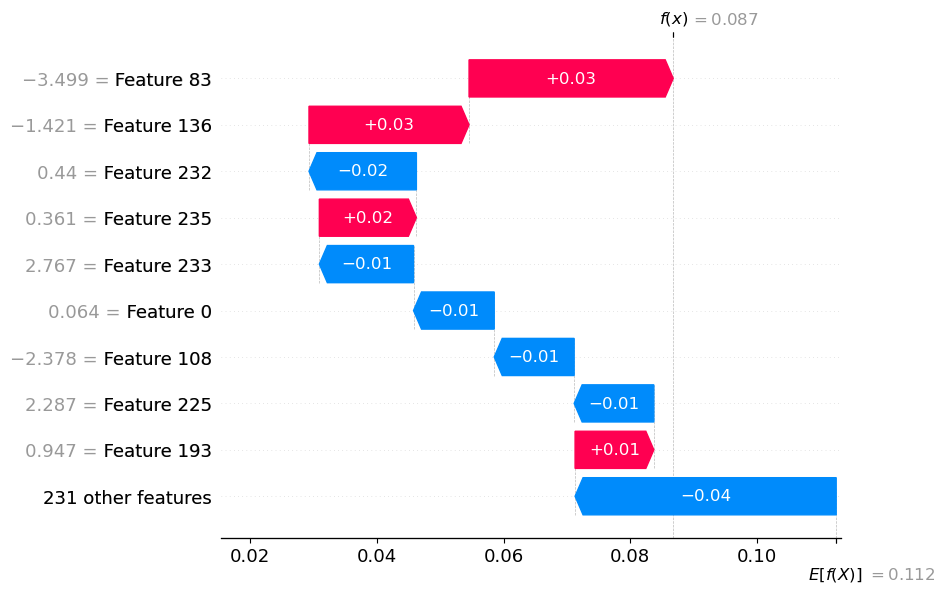

In [15]:
import numpy as np
died_indices = np.where(y_test == 1)[0]
if len(died_indices) > 0:
    model.explain_prediction(X_test, idx=died_indices[0])


PermutationExplainer explainer: 2001it [01:42, 17.59it/s]                          


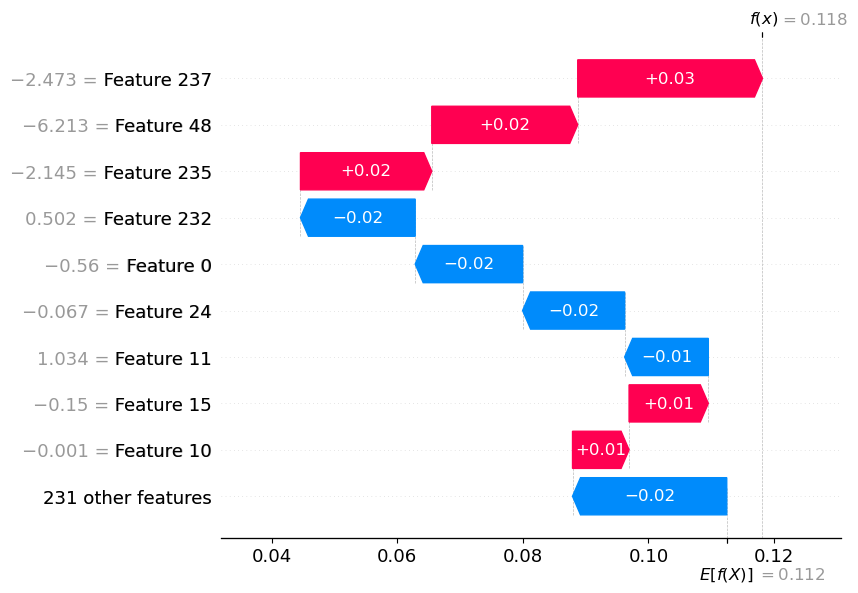

In [16]:
survived_indices = np.where(y_test == 0)[0]
if len(survived_indices) > 0:
    model.explain_prediction(X_test, idx=survived_indices[0])
